🔥Exploration of Random Forest Classifier for Deep Tennis Learning based on predict Proba

Conclusion : Good results found with 40% of bounces found and an average shift of 2 frames for bounces not found

Published Results at the End of the notebook with RFBouncePred.csv and RFball_pred.csv including predicted bounced

In [349]:
from io import StringIO

import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

DATA_URL = 'https://github.com/ArtLabss/tennis-tracking/raw/main/Bounces/BigDataFrame.csv'

In [350]:
resp = requests.get(DATA_URL)

In [351]:
df_ball = pd.read_csv(StringIO(resp.text))
df_ball

,x,y,V,bounce
0,961.000,856.000,22.707046,0
1,954.000,852.000,0.000000,0
2,954.000,852.000,0.000000,0
3,954.000,852.000,0.000000,0
4,954.000,852.000,0.000000,0
...,...,...,...,...
3669,1156.750,242.750,22.062762,0
3670,1169.375,239.375,21.409956,0
3671,1182.000,236.000,13.623924,0
3672,1183.000,244.000,15.243072,0


In [352]:
# On ajoute les colonnes donnant les daltas des position/vitesses par rapport aux instants dans le passé et le futur

def lag_df(lag):
    df = df_ball.drop(columns='bounce')
    df = df.shift(lag) - df
    df.rename(columns={'x':f'x_lagdelta:{lag}', 'y':f'y_lagdelta:{lag}', 'V':f'V_lagdelta:{lag}'}, inplace=True)
    return df

df_ball_lag = pd.concat([
    *(lag_df(i) for i in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]),
    df_ball
], axis=1)

df_ball_lag = df_ball_lag.dropna()

df_ball_lag

,x_lagdelta:-5,y_lagdelta:-5,V_lagdelta:-5,x_lagdelta:-4,y_lagdelta:-4,V_lagdelta:-4,x_lagdelta:-3,y_lagdelta:-3,V_lagdelta:-3,x_lagdelta:-2,...,x_lagdelta:4,y_lagdelta:4,V_lagdelta:4,x_lagdelta:5,y_lagdelta:5,V_lagdelta:5,x,y,V,bounce
5,6.000,-2.000,0.000000,6.000,-2.000,0.000000,5.000,2.000,12.123265,0.00,...,0.0,0.0,0.000000,7.000,4.000,22.707046,954.000,852.000,0.000000,0
6,6.000,-2.000,0.000000,6.000,-2.000,0.000000,6.000,-2.000,0.000000,5.00,...,0.0,0.0,0.000000,0.000,0.000,0.000000,954.000,852.000,0.000000,0
7,6.000,-2.000,-16.145013,6.000,-2.000,-16.145013,6.000,-2.000,-16.145013,6.00,...,0.0,0.0,-16.145013,0.000,0.000,-16.145013,954.000,852.000,16.145013,0
8,1.000,-4.000,-12.123265,1.000,-4.000,-12.123265,1.000,-4.000,-12.123265,1.00,...,-5.0,-2.0,-12.123265,-5.000,-2.000,-12.123265,959.000,854.000,12.123265,0
9,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.00,...,-6.0,2.0,0.000000,-6.000,2.000,0.000000,960.000,850.000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3664,63.125,-16.875,0.233068,50.500,-13.500,0.220917,37.875,-10.125,-0.331499,25.25,...,-50.5,13.5,-5.716588,-63.125,16.875,0.261140,1093.625,259.625,21.829694,0
3665,63.125,-16.875,-0.798812,50.500,-13.500,-0.146006,37.875,-10.125,-0.158157,25.25,...,-50.5,13.5,0.194801,-63.125,16.875,-6.095662,1106.250,256.250,22.208768,0
3666,63.125,-16.875,-8.776138,50.500,-13.500,-0.990106,37.875,-10.125,-0.337300,25.25,...,-50.5,13.5,-0.143563,-63.125,16.875,0.003507,1118.875,252.875,22.400062,0
3667,51.500,-5.500,-6.255122,50.500,-13.500,-7.874271,37.875,-10.125,-0.088238,25.25,...,-50.5,13.5,1.176374,-63.125,16.875,0.758305,1131.500,249.500,21.498194,0


In [543]:
nb_test = 500

In [544]:
# Train/test split

X = df_ball_lag.iloc[:, :-1]
y = df_ball_lag.iloc[:, -1]
X_train = df_ball_lag.iloc[:-nb_test, :-1]
y_train = df_ball_lag.iloc[:-nb_test, -1]
X_test = df_ball_lag.iloc[-nb_test:, :-1]
y_test = df_ball_lag.iloc[-nb_test:, -1]

In [545]:
def create_ball_pred(df_ball,my_pred_df):

    X = df_ball.iloc[:, :] 
    X_test = X.iloc[-nb_test:, :]
    
    for i in range(len(my_pred_df)):
        X_test['bounce'].iloc[i]=my_pred_df.iloc[i];
        
#     print(X_test[X_test['bounce']==1]) 
    return pd.DataFrame(X_test)

In [546]:
def evaluate_score(my_df) : 
    
    idx=my_df[['score']].idxmax()
    max_val=my_df['score'][idx[0]]
    best_estimator=my_df['n_estimators'][idx[0]]
    print(f"Best ROC score is {max_val} found for estimators : {best_estimator}")

In [547]:
# Le modele consiste à appliquer un standart scaler puis un random forest
global_list=[]
n_estimators= 500


model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
)
my_roc_auc_score={}

model.fit(X_train, y_train)
y_test_pred_proba = model.predict_proba(X_test)[:,1]
roc = pd.DataFrame(dict(zip(['false_positive_rate', 'true_positive_rate', 'thresholds'], roc_curve(y_test, y_test_pred_proba))))
score=roc_auc_score(y_test, y_test_pred_proba)

my_roc_auc_score['n_estimators']=n_estimators
my_roc_auc_score['score']=round(score,3)

print(my_roc_auc_score)
global_list.append(my_roc_auc_score)
my_roc_auc_score_df=pd.DataFrame(global_list)
evaluate_score(my_roc_auc_score_df)



{'n_estimators': 500, 'score': 0.924}
Best ROC score is 0.924 found for estimators : 500


In [548]:
def final_analysis(y_pred,y_test) :

    nb_pred_bounces=y_pred.sum()
    y_test_resetindex=y_test.reset_index()
    y_test2=pd.DataFrame(y_test_resetindex['bounce'])
    nb_true_bounces=y_test2.sum()[0]
    
    my_list=[];max_error=0; exact_match=0
    for i in range(len(y_pred)):
        if (y_pred[i]==1 and y_test2.iloc[i][0] ==1 ) :
            exact_match+=1
        diff=y_pred[i]-y_test2.iloc[i][0]
        max_error+=abs(diff)
        my_list.append(diff)
    my_diff_df=pd.DataFrame(my_list)
    
    print(f"True Bounces : {nb_true_bounces}, Predicted Bounces : {nb_pred_bounces}")
    print(f"Ratio of exact Predicted Bounces found: {round(abs(exact_match/nb_true_bounces)*100,0)}%")
    print(f"Average shift per false prediction :{round(max_error/(nb_true_bounces-exact_match),1)} frames shift")
    
    return my_diff_df


In [549]:
def final_display(y_pred,y_test,my_diff_df) :
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,0.5))
    ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-0.1,1.1))
    ax3= fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1, 1))
    
    ax1.set_ylabel("Bounces predicted")
    ax1.plot(y_pred, color='r')
    
    ax2.set_ylabel("Real Bounces")
    ax2.plot(y_test,color='b');
    
    ax3.set_ylabel("Diff")
    ax3.plot(my_diff_df,color='black')

### BASED Y_Predict on predict_proba weights - see Graph

pred    0   1
true         
0     431  57
1       1  11


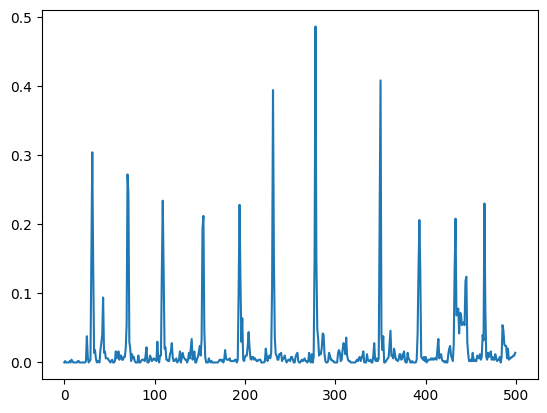

In [550]:
# Threshold defined based on experiments 
thres=0.85
eps = roc[roc['true_positive_rate']>thres]['thresholds'].iloc[0]

y_test_pred = (y_test_pred_proba >= eps).astype('int')
plt.plot(y_test_pred_proba)

print(pd.crosstab(pd.Series(y_test.values, name='true'), pd.Series(y_test_pred, name='pred')))

True Bounces : 12, Predicted Bounces : 68
Ratio of exact Predicted Bounces found: 92.0%
Average shift per false prediction :58.0 frames shift


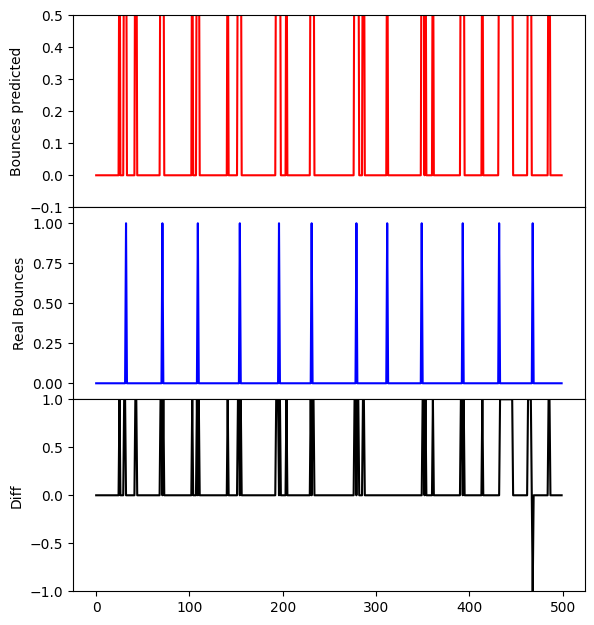

In [551]:
#UNFILTERED RESULT
diff_df=final_analysis(y_test_pred,y_test)
final_display(y_test_pred,y_test,diff_df)

In [552]:
#cleanup the next NB_ITER frames to eliminate False Bounces
NB_ITER=25


In [553]:
def prediction_bounce(prediction_list):

    final_round=0
    for j in range(len(prediction_list)):
        if prediction_list[j]==1 and final_round==0:
            #create window of proba
            nb_iter=NB_ITER
            if (j+NB_ITER) > len(prediction_list):
                nb_iter=len(prediction_list)-j
                final_round=1

            my_list=y_test_pred_proba[j:j+nb_iter]
            index_max=my_list.argmax()

            prediction_list[j+index_max]=1
            for k in range(0,index_max) :
                prediction_list[j+k]=0
            for k in range(index_max+1,nb_iter) :
                prediction_list[j+k]=0

    return prediction_list

True Bounces : 12, Predicted Bounces : 12
Ratio of exact Predicted Bounces found: 42.0%
Average shift per false prediction :2.0 frames shift


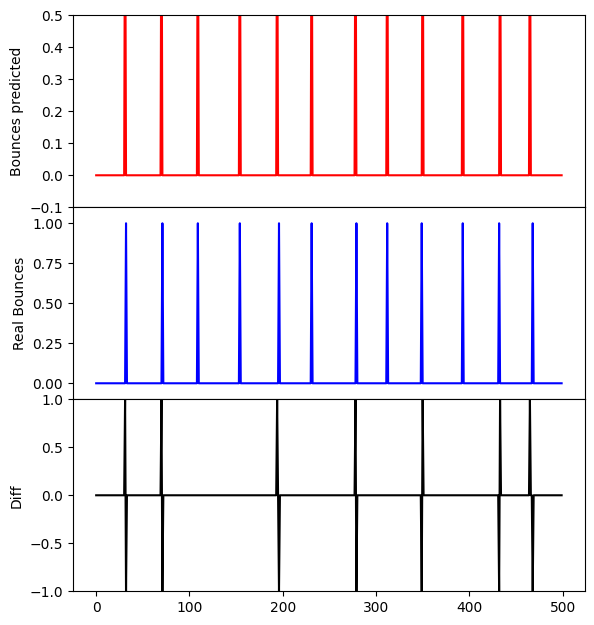

In [554]:
yprediction=prediction_bounce(y_test_pred)
diff_df=final_analysis(yprediction,y_test)
final_display(prediction_list,y_test,diff_df)


In [555]:
RFbounce_pred=pd.DataFrame(prediction_list)
RFbounce_pred.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/tristan_model/RFBouncePred.csv', index=False, header=True)

RFball_pred=create_ball_pred(df_ball,RFbounce_pred)
RFball_pred.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/tristan_model/RFball_pred.csv', index=False, header=True)


/tmp/ipykernel_3294/620959895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['bounce'].iloc[i]=my_pred_df.iloc[i];


In [556]:
nb_test_val =np.arange(100,1500,100)

for nb_test in nb_test_val:
    X = df_ball_lag.iloc[:, :-1]
    y = df_ball_lag.iloc[:, -1]
    X_train = df_ball_lag.iloc[:-nb_test, :-1]
    y_train = df_ball_lag.iloc[:-nb_test, -1]
    X_test = df_ball_lag.iloc[-nb_test:, :-1]
    y_test = df_ball_lag.iloc[-nb_test:, -1]
    n_estimators= 500


    model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    )

    model.fit(X_train, y_train)
    y_test_pred_proba = model.predict_proba(X_test)[:,1]

    eps = roc[roc['true_positive_rate']>thres]['thresholds'].iloc[0]
    y_test_pred = (y_test_pred_proba >= eps).astype('int')
    print(f"**Test set size {nb_test} which is {round((nb_test/3740)*100,0)} % of full Dataset   *********")
    list=pd.crosstab(pd.Series(y_test.values, name='true'), pd.Series(y_test_pred, name='pred'))
    TN=list[0][0];FN=list[0][1];FP=list[1][0];TP=list[1][1]
    print(f"Confusion Matrix [[{TN}    {FP}]")
    print(f"                  [{FN}      {TP}]]")

    y_pred_filtered=prediction_bounce(y_test_pred)
    diff_df=final_analysis(y_pred_filtered,y_test)
    print()

    

**Test set size 100 which is 3.0 % of full Dataset   *********
Confusion Matrix [[65    33]
                  [1      1]]
True Bounces : 2, Predicted Bounces : 3
Ratio of exact Predicted Bounces found: 0.0%
Average shift per false prediction :2.5 frames shift

**Test set size 200 which is 5.0 % of full Dataset   *********
Confusion Matrix [[166    29]
                  [1      4]]
True Bounces : 5, Predicted Bounces : 5
Ratio of exact Predicted Bounces found: 40.0%
Average shift per false prediction :2.0 frames shift

**Test set size 300 which is 8.0 % of full Dataset   *********
Confusion Matrix [[257    36]
                  [2      5]]
True Bounces : 7, Predicted Bounces : 7
Ratio of exact Predicted Bounces found: 14.0%
Average shift per false prediction :2.0 frames shift

**Test set size 400 which is 11.0 % of full Dataset   *********
Confusion Matrix [[339    51]
                  [1      9]]
True Bounces : 10, Predicted Bounces : 10
Ratio of exact Predicted Bounces found: 40.0%
A

Conclusion : Good results with an average shift of 2 frames and 40% of bounces found